In [1]:
from cifar10_models.vgg import vgg11_bn, vgg13_bn, vgg16_bn, vgg19_bn

# Untrained model
teacher = vgg13_bn()
student = vgg13_bn()

# Pretrained model
teacher = vgg13_bn(pretrained=True)
teacher.eval() # for evaluation

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

cuda:0
Files already downloaded and verified
Files already downloaded and verified


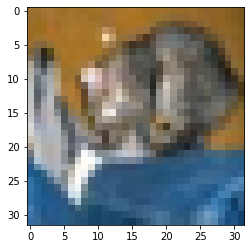

GroundTruth:  cat  
Predicted:  cat  
Accuracy of the network on the 10000 test images: 87 %
Accuracy for class: plane is 88.5 %
Accuracy for class: car   is 90.3 %
Accuracy for class: bird  is 84.6 %
Accuracy for class: cat   is 88.1 %
Accuracy for class: deer  is 93.2 %
Accuracy for class: dog   is 73.1 %
Accuracy for class: frog  is 92.7 %
Accuracy for class: horse is 85.4 %
Accuracy for class: ship  is 95.0 %
Accuracy for class: truck is 87.2 %


In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
teacher.to(device)
student.to(device)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 1

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

images, labels = images.to(device),  labels.to(device)
outputs = teacher(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(batch_size)))

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs

for data in testloader:
    images, labels = data
    images, labels = data[0].to(device), data[1].to(device)

    # calculate outputs by running images through the network
    outputs = teacher(images)
    # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        
        outputs = teacher(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


In [2]:
import numpy as np
import maxflow
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import cv2

In [3]:
def display_img_arr(img_arr, r, c, dim,titles_arr):
    fl = 0
    fig = plt.figure(figsize = dim)
    for i in range(r):
        for j in range(c):
            if len(img_arr) == fl:
                break
            ax1 = fig.add_subplot(r, c, fl + 1)
            ax1.set_title(titles_arr[fl], fontsize = 20)
            ax1.imshow(img_arr[fl], cmap = 'gray')
            fl = fl + 1
    plt.show()

In [4]:
import numpy as np
import maxflow
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

def display_img_arr(img_arr, r, c, dim,titles_arr):
    fl = 0
    fig = plt.figure(figsize = dim)
    for i in range(r):
        for j in range(c):
            if len(img_arr) == fl:
                break
            ax1 = fig.add_subplot(r, c, fl + 1)
            ax1.set_title(titles_arr[fl], fontsize = 20)
            ax1.imshow(img_arr[fl], cmap = 'gray')
            fl = fl + 1
    plt.show()
    
class GrabCut:
    def __init__(self, img, gamma, k, max_iter, bgRect, mask, iters):
        self.height = img.shape[1]
        self.width = img.shape[0]

        self.k = k
        self.gamma = gamma
        self.img = img.astype(np.float64)
        
        self.graph = maxflow.GraphFloat()
        self.pixels = self.graph.add_grid_nodes(self.img.shape[:2])
        
        self.set_beta()
        print("self.beta = ", self.beta)

        self.set_graph_weights()
        
        self.BG = 0 # Sure Background
        self.FG = 1 # Sure Foreground
        self.PR_BG = 2  #Probable background
        self.PR_FG = 3 #Probable foreground

        self.init_trimap(mask, bgRect)
        self.add_terminal_edges()
        self.iterative_step(iters, max_iter)
        

    def set_beta(self):
        beta = 0
        # calculates average over an image sample for (z_m-z_n)^2 for 
        self._left_diff = self.img[:, 1:] - self.img[:, :-1] # Left-difference
        self._upleft_diff = self.img[1:, 1:] - self.img[:-1, :-1] # Up-Left difference
        self._up_diff = self.img[1:, :] - self.img[:-1, :] # Up-difference
        self._upright_diff = self.img[1:, :-1] - self.img[:-1, 1:] # Up-Right difference
        # beta is as described in the paper
        beta = (self._left_diff*self._left_diff).sum() + (self._upleft_diff*self._upleft_diff).sum() \
            + (self._up_diff*self._up_diff).sum() + (self._upright_diff*self._upright_diff).sum() # According to the formula
        self.beta = 1/(2*beta/(4*self.width*self.height - 3*self.width - 3*self.height + 2))
        # 4*self.width*self.height - 3*self.width - 3*self.height + 2 is the number of pairs of neighbouring pixels in the image

    def set_graph_weights(self):
        for i in range(self.height):
            for j in range(self.width):
                current_pixel = self.pixels[j, i]
                if j-1 >= 0: # if top neighbor exists
                    dest_node = self.pixels[j-1, i]
                    temp = np.sum((self.img[j, i] - self.img[j-1, i])**2)
                    wt = np.exp(-self.beta * temp)
                    
                    n_link = self.gamma/1 * wt
                    self.graph.add_edge(current_pixel, dest_node , n_link, n_link)

                if i-1 >= 0: # if left neighbor exists
                    dest_node = self.pixels[j, i-1]
                    temp = np.sum((self.img[j, i] - self.img[j, i-1])**2)
                    wt = np.exp(-self.beta * temp)
                    n_link = self.gamma/1 * wt
                    self.graph.add_edge(current_pixel, dest_node, n_link, n_link)
                
                if i-1 >= 0 and j-1 >= 0: # if top left neighbor exists
                    dest_node  = self.pixels[j-1, i-1]
                    temp = np.sum((self.img[j, i] - self.img[j-1, i-1])**2)
                    wt = np.exp(-self.beta * temp )
                    n_link = self.gamma/np.sqrt(2) * wt
                    self.graph.add_edge(current_pixel, dest_node, n_link, n_link)
                
                if i+1 < self.height and j-1 >= 0: # if top right neighbor exists
                    temp = np.sum((self.img[j, i] - self.img[j-1, i+1])**2)
                    wt = np.exp(-self.beta * temp)
                    n_link = self.gamma/np.sqrt(2) * wt
                    self.graph.add_edge(current_pixel, dest_node, n_link, n_link)


    def init_trimap(self, mask, bgRect):
        self.bgRect = bgRect
        x, y, w, h = bgRect
        temp  = np.ones(shape = self.img.shape[:2])

       
        self.trimap = self.BG * temp # Initially all trimap background
        self.trimap[np.where(mask == 0)] = self.BG # Sure background
        y_start = y
        y_end = y_start+h+1
        x_start = x
        x_end = x_start+w+1

        self.trimap[y_start:y_end, x_start:x_end] = self.PR_FG # trimap unknown set
        self.trimap[np.where(mask == 1)] = self.FG # Sure foreground

    def add_terminal_edges(self):
        x, y = np.where(self.trimap == self.FG)

        for i in range(len(x)):
            x_i = x[i]
            y_i = y[i]
            edge = self.pixels[x_i, y_i]
            self.graph.add_tedge(edge, np.inf, 0)
        
        x, y = np.where(self.trimap == self.BG)
        
        for i in range(len(x)):
            x_i = x[i]
            y_i = y[i]
            edge = self.pixels[x_i, y_i]
            self.graph.add_tedge(edge, 0, np.inf)

    def set_cov_inv(self):
        self.cov_inv_fg =  np.linalg.inv(self.fg_gmm.covariances_)
        self.cov_inv_bg =  np.linalg.inv(self.bg_gmm.covariances_)

    def set_cov_det(self):
        self.bg_cov_det = np.linalg.det(self.bg_gmm.covariances_)
        self.fg_cov_det = np.linalg.det(self.fg_gmm.covariances_)

    def set_kmeans(self, max_iter):
        self.bg_kmeans = KMeans(n_clusters=self.k, max_iter = max_iter)
        self.fg_kmeans = KMeans(n_clusters=self.k, max_iter = max_iter)

    def set_gmm(self):
        self.bg_gmm = GaussianMixture(n_components = self.k)
        self.fg_gmm = GaussianMixture(n_components = self.k)

    def iterative_step(self, iters, max_iter):
        for i in range(iters):
            print(f"Iteration {i+1}")
            bg_indices = np.where(np.logical_or(self.trimap == self.BG, self.trimap == self.PR_BG))
            fg_indices = np.where(np.logical_or(self.trimap == self.FG, self.trimap == self.PR_FG))

            bg_set = self.img[bg_indices]
            fg_set = self.img[fg_indices]


            self.set_kmeans(max_iter)
            BG_GMM = np.empty(shape = len(bg_set), dtype = int)
            FG_GMM = np.empty(shape = len(fg_set), dtype = int)

            BG_KM = self.fg_kmeans.fit(bg_set) # K Means for background pixels
            FG_KM = self.fg_kmeans.fit(fg_set) # K Means for foreground pixels
            
            self.set_gmm()

            self.bg_gmm.fit(bg_set, BG_KM.labels_)
            self.fg_gmm.fit(fg_set, FG_KM.labels_)
           
            BG_GMM = self.bg_gmm.predict(bg_set)
            FG_GMM = self.fg_gmm.predict(fg_set)

            self.bg_gmm.fit(bg_set, BG_GMM)
            self.fg_gmm.fit(fg_set, FG_GMM)

            self.set_cov_det()

            D_bg = self.bg_gmm.weights_ / np.sqrt(self.bg_cov_det)
            D_fg = self.fg_gmm.weights_ / np.sqrt(self.fg_cov_det)
            
            self.set_cov_inv()
            tedge_weights_bg = np.empty(shape = (self.img.shape[0],self.img.shape[1]),dtype = np.float64)
            tedge_weights_fg = np.empty(shape = (self.img.shape[0],self.img.shape[1]), dtype = np.float64)
            
            r_ind, c_ind = np.where(np.logical_or(self.trimap == self.PR_BG, self.trimap == self.PR_FG))
            
            for k in range(len(r_ind)):
                node = self.img[r_ind[k], c_ind[k]]
                D_BG = 0
                D_FG = 0
                for j in range(self.k):
                    bg_u = self.bg_gmm.means_[j]
                    fg_u = self.fg_gmm.means_[j]
                    D_BG += D_bg[j] * np.exp(-0.5 * (node - bg_u).reshape(1, 3) @ self.cov_inv_bg[j] @ (node - bg_u).reshape(3, 1))[0][0] 
                    D_FG += D_fg[j] * np.exp(-0.5 * (node - fg_u).reshape(1, 3) @ self.cov_inv_fg[j] @ (node - fg_u).reshape(3, 1))[0][0]

                tedge_weights_fg[r_ind[k], c_ind[k]] = -np.log(D_BG)
                tedge_weights_bg[r_ind[k], c_ind[k]] = -np.log(D_FG)

                self.graph.add_tedge(self.pixels[r_ind[k], c_ind[k]], tedge_weights_fg[r_ind[k], c_ind[k]], tedge_weights_bg[r_ind[k], c_ind[k]])
            
           
            self.graph.maxflow()
          
            for j in range(len(r_ind)):
                edge = self.pixels[r_ind[j], c_ind[j]]
                self.graph.add_tedge(edge, -tedge_weights_fg[r_ind[j], c_ind[j]], -tedge_weights_bg[r_ind[j], c_ind[j]])
                
                if self.graph.get_segment(edge) == 0:
                    self.trimap[r_ind[j], c_ind[j]] = self.PR_FG
                else:
                    self.trimap[r_ind[j], c_ind[j]] = self.PR_BG

In [5]:
class EventHandler:
    """
    Class for handling user input during segmentation iterations 
    """
    
    def __init__(self, flags, img, _mask, colors):
        
        self.FLAGS = flags
        self.ix = -1
        self.iy = -1
        self.img = img
        self.img2 = self.img.copy()
        self._mask = _mask
        self.COLORS = colors

    @property
    def image(self):
        return self.img
    
    @image.setter
    def image(self, img):
        self.img = img
        
    @property
    def mask(self):
        return self._mask
    
    @mask.setter
    def mask(self, _mask):
        self._mask = _mask
    
    @property
    def flags(self):
        return self.FLAGS 
    
    @flags.setter
    def flags(self, flags):
        self.FLAGS = flags
    
    def handler(self, event, x, y, flags, param):

        # Draw the rectangle first
        if event == cv2.EVENT_RBUTTONDOWN:
            self.FLAGS['DRAW_RECT'] = True
            self.ix, self.iy = x,y

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_RECT'] == True:
                self.img = self.img2.copy()
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0

        elif event == cv2.EVENT_RBUTTONUP:
            self.FLAGS['DRAW_RECT'] = False
            self.FLAGS['rect_over'] = True
            cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
            self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
            self.FLAGS['rect_or_mask'] = 0
        
        # Draw strokes for refinement 

        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                print('Draw the rectangle first.')
            else:
                self.FLAGS['DRAW_STROKE'] = True
                cv2.circle(self.img, (x,y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x,y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_STROKE'] == True:
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['DRAW_STROKE'] == True:
                self.FLAGS['DRAW_STROKE'] = False
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

In [6]:
def run(infolder, filename: str, outfolder, iters, gamma, k):
    """
    Main loop that implements GrabCut. 
    
    Input
    -----
    filename (str) : Path to image
    """
    
    COLORS = {
    'BLACK' : [0,0,0],
    'RED'   : [0, 0, 255],
    'GREEN' : [0, 255, 0],
    'BLUE'  : [255, 0, 0],
    'WHITE' : [255,255,255]
    }

    DRAW_BG = {'color' : COLORS['BLACK'], 'val' : 0}
    DRAW_FG = {'color' : COLORS['WHITE'], 'val' : 1}

    FLAGS = {
        'RECT' : (0, 0, 1, 1),
        'DRAW_STROKE': False,         # flag for drawing strokes
        'DRAW_RECT' : False,          # flag for drawing rectangle
        'rect_over' : False,          # flag to check if rectangle is  drawn
        'rect_or_mask' : -1,          # flag for selecting rectangle or stroke mode
        'value' : DRAW_FG,            # drawing strokes initialized to mark foreground
    }

    img = cv2.imread(infolder+filename)
    img2 = img.copy()                                
    mask = 10 * np.ones(img.shape[:2], dtype = np.uint8) # mask is a binary array with : 0 - background pixels
                                                         #                               1 - foreground pixels, 10 - initial value
    output = np.zeros(img.shape, np.uint8)           # output image to be shown

    # Input and segmentation windows
    cv2.namedWindow('Input Image')
    cv2.namedWindow('Segmented output')
    
    EventObj = EventHandler(FLAGS, img, mask, COLORS)
    cv2.setMouseCallback('Input Image', EventObj.handler)
    cv2.moveWindow('Input Image', img.shape[1] + 10, 90)

    gc = None # grab cut object
    
    while(1):
        
        img = EventObj.image
        mask = EventObj.mask
        FLAGS = EventObj.flags
        cv2.imshow('Segmented output', output)
        cv2.imshow('Input Image', img)
        
        k = cv2.waitKey(1)

        # key bindings
        if k == 27:
            # esc to exit
            break
        
        elif k == ord('0'): 
            # Strokes for background
            FLAGS['value'] = DRAW_BG
        
        elif k == ord('1'):
            # FG drawing
            FLAGS['value'] = DRAW_FG
        
        elif k == ord('r'):
            # reset everything
            FLAGS['RECT'] = (0, 0, 1, 1)
            FLAGS['DRAW_STROKE'] = False
            FLAGS['DRAW_RECT'] = False
            FLAGS['rect_or_mask'] = -1
            FLAGS['rect_over'] = False
            FLAGS['value'] = DRAW_FG
            img = img2.copy()
            mask = 10 * np.ones(img.shape[:2], dtype = np.uint8) 
            EventObj.image = img
            EventObj.mask = mask
            output = np.zeros(img.shape, np.uint8)
      
        elif k == 13: 
            FLAGS['DRAW_RECT'] = False
            FLAGS['rect_over'] = True
            # Press carriage return to initiate segmentation
            
            #-------------------------------------------------#
            # Implement GrabCut here.                         #  
            # Function should return a mask which can be used #
            # to segment the original image as shown on L90   # 
            #-------------------------------------------------#
            
            #---------------- Initialization ----------------#
        
            print('starting grabcut')
            print(FLAGS['RECT'])
            
            gc = GrabCut(img2,gamma, k, 10, FLAGS['RECT'], mask, iters)
            img_res = np.zeros(img2.shape).astype(np.uint8)
            ind = np.where(np.logical_or(gc.trimap == gc.FG, gc.trimap == gc.PR_FG))
            
            img_res[ind] = img2[ind]
            img_res = cv2.cvtColor(img_res, cv2.COLOR_BGR2RGB)
            print('finished grabcut, select fg by pressing 1, bg by pressing 0 ')
            plt.imsave(outfolder+filename,img_res)
            display_img_arr([img_res], 1, 3, (20, 20), ['resultant img'])

        EventObj.flags = FLAGS
        mask2 = np.where((mask == 1), 255, 0).astype('uint8')
        output = cv2.bitwise_and(img2, img2, mask = mask2)

self.beta =  5.48152837297821
Iteration 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


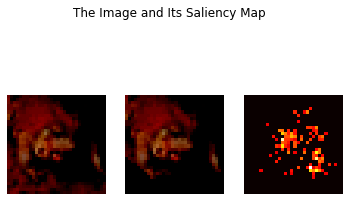

self.beta =  8.071167758400492
Iteration 1


/home/anirudh/.local/lib/python3.6/site-packages/ipykernel_launcher.py:190: RuntimeWarning: divide by zero encountered in log
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


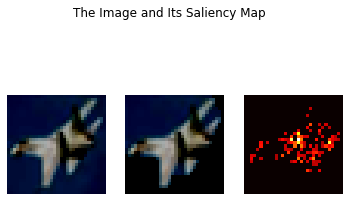

self.beta =  2.6009907240334664
Iteration 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


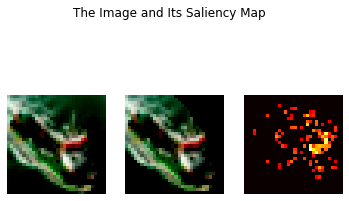

self.beta =  4.361185075190918
Iteration 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


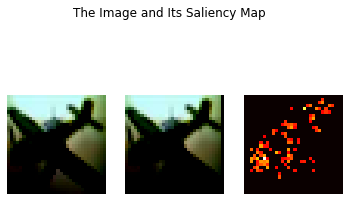

In [9]:
for ind,data in enumerate(testloader):
    if ind in [5,10,15,27]:
        image, label = data
        img2 = image.numpy()
        image, label = image.to(device), label.to(device)
        image.requires_grad_()

        # Retrieve output from the image
        output = teacher(image)

        # Catch the output
        output_idx = output.argmax()
        output_max = output[0, output_idx]

        # Do backpropagation to get the derivative of the output based on the image
        output_max.backward()

        # Retireve the saliency map and also pick the maximum value from channels on each pixel.
        # In this case, we look at dim=1. Recall the shape (batch_size, channel, width, height)
        saliency, _ = torch.max(image.grad.data.abs(), dim=1) 
        saliency_val = np.percentile(saliency.cpu().numpy(), 90)
        saliency[saliency < saliency_val] = 0
        saliency = saliency.reshape(32, 32)
        mask = saliency.detach().cpu().numpy()
        img2 = img2.reshape(3,32,32)
        img2 = np.transpose(img2,(1,2,0))
        gc = GrabCut(img2,50, 5, 10, (0,0,30,30), mask, 1)
        
        fig, ax = plt.subplots(1, 3)
        image = image.reshape(-1, 32, 32)
        img = image.cpu().detach().numpy().transpose(1, 2, 0)


        ax[0].imshow(image.cpu().detach().numpy().transpose(1, 2, 0))
        ax[0].axis('off')
        img[np.where(np.logical_or(gc.trimap == gc.BG , gc.trimap == gc.PR_BG))] = 0 
        ax[1].imshow(img, cmap='hot')
        ax[1].axis('off')
        ax[2].imshow(saliency.cpu(), cmap='hot')
        ax[2].axis('off')


        fig.suptitle('The Image and Its Saliency Map')
        plt.show()
        

    # Reshape the image
#     image = image.reshape(-1, 32, 32)
    


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 24, 24, 25, 25, 25, 25, 25, 26, 26,
       26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28,
       28, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31]), array([31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 16, 17, 31, 15, 16, 17, 18, 31, 14, 15,
       16, 17, 18, 19, 31, 14, 15, 16, 17, 18, 19, 20, 21, 31, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 31,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 31,  0,  1,  2,  3,  4,  5,  6,
       

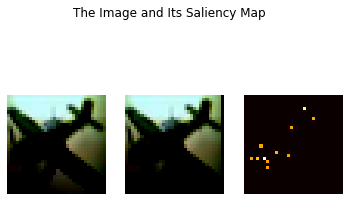

In [5]:
for data in testloader:
    break
    image, label = data


    image, label = image.to(device), label.to(device)
    image.requires_grad_()

    # Retrieve output from the image
    output = teacher(image)

    # Catch the output
    output_idx = output.argmax()
    output_max = output[0, output_idx]

    # Do backpropagation to get the derivative of the output based on the image
    output_max.backward()

    # Retireve the saliency map and also pick the maximum value from channels on each pixel.
    # In this case, we look at dim=1. Recall the shape (batch_size, channel, width, height)
    saliency, _ = torch.max(image.grad.data.abs(), dim=1) 
    saliency = saliency.reshape(32, 32)

    # Reshape the image
    image = image.reshape(-1, 32, 32)


    # Visualize the image and the saliency map
    # fig, ax = plt.subplots(1, 2)
    # ax[0].imshow(image[0].cpu().detach().numpy().transpose(1, 2, 0))
    # ax[0].axis('off')
    # ax[1].imshow(saliency[0].cpu(), cmap='hot')
    # ax[1].axis('off')


    # plt.tight_layout()
    # fig.suptitle('The Image and Its Saliency Map')
    # plt.show()

    # Visualize the image and the saliency map
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image.cpu().detach().numpy().transpose(1, 2, 0))
    ax[0].axis('off')
    ax[1].imshow(saliency.cpu(), cmap='hot')
    ax[1].axis('off')

    fig.suptitle('The Image and Its Saliency Map')
    plt.show()



Random Seed:  999
DataParallel(
  (module): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, s

[0/5][2450/50000]	Loss_D: 0.0856	Loss_G: 6.2018	D(x): 0.9199	D(G(z)): 0.0020 / 0.0020
[0/5][2500/50000]	Loss_D: 0.0176	Loss_G: 4.4859	D(x): 0.9945	D(G(z)): 0.0120 / 0.0113
[0/5][2550/50000]	Loss_D: 0.0409	Loss_G: 4.7030	D(x): 0.9696	D(G(z)): 0.0100 / 0.0091
[0/5][2600/50000]	Loss_D: 0.1917	Loss_G: 5.7903	D(x): 0.8307	D(G(z)): 0.0062 / 0.0031
[0/5][2650/50000]	Loss_D: 0.8433	Loss_G: 3.8451	D(x): 0.4874	D(G(z)): 0.1172 / 0.0214
[0/5][2700/50000]	Loss_D: 1.1865	Loss_G: 4.4357	D(x): 0.9396	D(G(z)): 0.6751 / 0.0118
[0/5][2750/50000]	Loss_D: 0.1122	Loss_G: 4.1343	D(x): 0.9400	D(G(z)): 0.0491 / 0.0160
[0/5][2800/50000]	Loss_D: 0.2249	Loss_G: 4.7956	D(x): 0.8066	D(G(z)): 0.0099 / 0.0083
[0/5][2850/50000]	Loss_D: 0.1921	Loss_G: 4.4289	D(x): 0.9347	D(G(z)): 0.1171 / 0.0119
[0/5][2900/50000]	Loss_D: 1.8726	Loss_G: 2.7421	D(x): 0.9502	D(G(z)): 0.8382 / 0.0644
[0/5][2950/50000]	Loss_D: 0.0808	Loss_G: 6.3641	D(x): 0.9260	D(G(z)): 0.0040 / 0.0017
[0/5][3000/50000]	Loss_D: 0.0820	Loss_G: 6.2369	D(x): 

[0/5][7250/50000]	Loss_D: 2.4952	Loss_G: 9.8080	D(x): 0.0825	D(G(z)): 0.0000 / 0.0001
[0/5][7300/50000]	Loss_D: 0.0194	Loss_G: 8.6079	D(x): 0.9810	D(G(z)): 0.0002 / 0.0002
[0/5][7350/50000]	Loss_D: 0.0007	Loss_G: 8.1559	D(x): 0.9997	D(G(z)): 0.0004 / 0.0003
[0/5][7400/50000]	Loss_D: 0.0029	Loss_G: 10.9427	D(x): 0.9971	D(G(z)): 0.0000 / 0.0000
[0/5][7450/50000]	Loss_D: 0.0046	Loss_G: 6.1257	D(x): 0.9980	D(G(z)): 0.0026 / 0.0022
[0/5][7500/50000]	Loss_D: 0.0036	Loss_G: 8.1218	D(x): 0.9967	D(G(z)): 0.0003 / 0.0003
[0/5][7550/50000]	Loss_D: 0.0012	Loss_G: 11.0161	D(x): 0.9989	D(G(z)): 0.0000 / 0.0000
[0/5][7600/50000]	Loss_D: 0.0015	Loss_G: 10.0466	D(x): 0.9986	D(G(z)): 0.0000 / 0.0000
[0/5][7650/50000]	Loss_D: 0.0037	Loss_G: 7.6184	D(x): 0.9969	D(G(z)): 0.0005 / 0.0005
[0/5][7700/50000]	Loss_D: 0.0425	Loss_G: 9.4126	D(x): 0.9627	D(G(z)): 0.0045 / 0.0001
[0/5][7750/50000]	Loss_D: 0.0004	Loss_G: 11.7560	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[0/5][7800/50000]	Loss_D: 0.0008	Loss_G: 10.4256	D

[0/5][12000/50000]	Loss_D: 0.0003	Loss_G: 10.4888	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[0/5][12050/50000]	Loss_D: 0.0001	Loss_G: 9.9135	D(x): 0.9999	D(G(z)): 0.0001 / 0.0000
[0/5][12100/50000]	Loss_D: 0.1477	Loss_G: 11.1349	D(x): 0.8627	D(G(z)): 0.0000 / 0.0000
[0/5][12150/50000]	Loss_D: 0.1537	Loss_G: 7.2300	D(x): 0.9995	D(G(z)): 0.1421 / 0.0007
[0/5][12200/50000]	Loss_D: 0.0002	Loss_G: 8.8720	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[0/5][12250/50000]	Loss_D: 0.0002	Loss_G: 9.2072	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[0/5][12300/50000]	Loss_D: 0.0001	Loss_G: 9.5786	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[0/5][12350/50000]	Loss_D: 0.0003	Loss_G: 11.6750	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[0/5][12400/50000]	Loss_D: 0.0003	Loss_G: 12.6604	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[0/5][12450/50000]	Loss_D: 0.0007	Loss_G: 10.2360	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000
[0/5][12500/50000]	Loss_D: 0.0006	Loss_G: 11.3354	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000
[0/5][12550/50000]	Loss_D: 0.0008	Los

[0/5][16700/50000]	Loss_D: 0.0324	Loss_G: 10.0963	D(x): 0.9682	D(G(z)): 0.0000 / 0.0000
[0/5][16750/50000]	Loss_D: 0.0004	Loss_G: 10.6104	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[0/5][16800/50000]	Loss_D: 0.0004	Loss_G: 8.7356	D(x): 0.9998	D(G(z)): 0.0002 / 0.0002
[0/5][16850/50000]	Loss_D: 0.0094	Loss_G: 12.5761	D(x): 0.9906	D(G(z)): 0.0000 / 0.0000
[0/5][16900/50000]	Loss_D: 0.0133	Loss_G: 6.1848	D(x): 0.9889	D(G(z)): 0.0021 / 0.0021
[0/5][16950/50000]	Loss_D: 0.0001	Loss_G: 10.3991	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[0/5][17000/50000]	Loss_D: 0.0005	Loss_G: 9.4858	D(x): 0.9996	D(G(z)): 0.0001 / 0.0001
[0/5][17050/50000]	Loss_D: 0.0271	Loss_G: 11.4837	D(x): 0.9733	D(G(z)): 0.0000 / 0.0000
[0/5][17100/50000]	Loss_D: 0.0002	Loss_G: 9.0061	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[0/5][17150/50000]	Loss_D: 0.0095	Loss_G: 10.4310	D(x): 0.9906	D(G(z)): 0.0000 / 0.0000
[0/5][17200/50000]	Loss_D: 0.0038	Loss_G: 12.5772	D(x): 0.9962	D(G(z)): 0.0000 / 0.0000
[0/5][17250/50000]	Loss_D: 0.0011	Lo

[0/5][21400/50000]	Loss_D: 0.0004	Loss_G: 11.8305	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[0/5][21450/50000]	Loss_D: 0.0002	Loss_G: 11.6669	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[0/5][21500/50000]	Loss_D: 0.0001	Loss_G: 13.1286	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[0/5][21550/50000]	Loss_D: 0.0001	Loss_G: 11.8897	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[0/5][21600/50000]	Loss_D: 0.0002	Loss_G: 10.9602	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[0/5][21650/50000]	Loss_D: 0.0010	Loss_G: 8.2692	D(x): 0.9993	D(G(z)): 0.0003 / 0.0003
[0/5][21700/50000]	Loss_D: 0.0001	Loss_G: 12.6237	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[0/5][21750/50000]	Loss_D: 0.0002	Loss_G: 13.3833	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[0/5][21800/50000]	Loss_D: 0.0002	Loss_G: 9.1575	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[0/5][21850/50000]	Loss_D: 0.0002	Loss_G: 15.0307	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[0/5][21900/50000]	Loss_D: 0.0000	Loss_G: 12.9329	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][21950/50000]	Loss_D: 0.0001	

KeyboardInterrupt: 

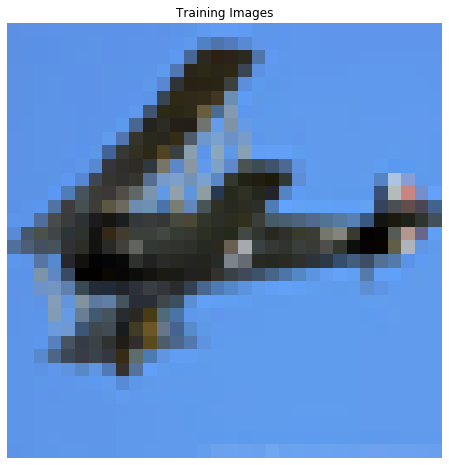

In [4]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torchvision

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Root directory for dataset
dataroot = "data/celeba"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 1

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 3 # only one for saliency map

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 32

# Size of feature maps in discriminator
ndf = 32

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 2

# We can use an image folder dataset the way we have it setup.
# Create the dataset

# Create the dataloader
dataloader = trainloader

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
teacher_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(teacher_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator Code

# class Generator(nn.Module):
#     def __init__(self, ngpu):
#         super(Generator, self).__init__()
#         self.ngpu = ngpu
#         self.main = nn.Sequential(
#             # input is Z, going into a convolution
#             nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
#             nn.BatchNorm2d(ngf * 8),
#             nn.ReLU(True),
#             # state size. (ngf*8) x 4 x 4
#             nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 4),
#             nn.ReLU(True),
#             # state size. (ngf*4) x 8 x 8
#             nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 2),
#             nn.ReLU(True),
#             # state size. (ngf*2) x 16 x 16
#             nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf),
#             nn.ReLU(True),
#             # state size. (ngf) x 32 x 32
#             nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
#             nn.Tanh()
#             # state size. (nc) x 64 x 64
#         )

#     def forward(self, input):
#         return self.main(input)

# Create the generator

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    student = nn.DataParallel(student, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
student.apply(weights_init)

# Print the model
print(student)


# init beta and gamma
beta = 2
gamma = 10
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 2 x 2
            nn.Conv2d(ndf * 8, 1, 2, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

# Initialize BCELoss function
criterion = nn.BCELoss()
criterion2 = nn.MSELoss()


# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
teacher_label = 1.
student_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(student.parameters(), lr=lr, betas=(beta1, 0.999))

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z))) = L_robust
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        image = data[0].to(device)
        
        image.requires_grad_()

        # Retrieve output from the image
        output = teacher(image)

        # Catch the output
        output_idx = output.argmax()
        output_max = output[0, output_idx]

        # Do backpropagation to get the derivative of the output based on the image
        output_max.backward()

        # Retireve the saliency map and also pick the maximum value from channels on each pixel.
        # In this case, we look at dim=1. Recall the shape (batch_size, channel, width, height)
        saliency = image.grad.data
        saliency = saliency.reshape(1,3,32, 32)
        
        # the input to the discriminator is the teacher saliency matrix instead of real images
        teacher_cpu = saliency
        b_size = teacher_cpu.size(0)
        label = torch.full((b_size,), teacher_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(teacher_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        
        
        fake = student(image)
        # Catch the output
        output_idx = fake.argmax()
        output_max = fake[0, output_idx]

        # Do backpropagation to get the derivative of the output based on the image
        output_max.backward()

        # Retireve the saliency map and also pick the maximum value from channels on each pixel.
        # In this case, we look at dim=1. Recall the shape (batch_size, channel, width, height)
        saliency = image.grad.data
        saliency = saliency.reshape(1,3,32, 32)
        label.fill_(student_label)
        # Classify all fake batch with D
        output = netD(saliency.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake # minimize L_robust
         
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: minimize Lce + Lrobust + Ldiff
        ###########################
        student.zero_grad()
        
        
        
        b_size = teacher_cpu.size(0)
        label = torch.full((b_size,), teacher_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(teacher_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        L_robust_1 = -beta*errD_real
        # Calculate gradients for D in backward pass
        L_robust_1.backward() 
        
        fake = student(image)
        # Catch the output
        output_idx = fake.argmax()
        output_max = fake[0, output_idx]

        # Do backpropagation to get the derivative of the output based on the image
        output_max.backward()

        # Retireve the saliency map and also pick the maximum value from channels on each pixel.
        # In this case, we look at dim=1. Recall the shape (batch_size, channel, width, height)
        saliency = image.grad.data
        saliency = saliency.reshape(1,3,32, 32)
        label.fill_(student_label)
        # Classify all fake batch with D
        output = netD(saliency.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        L_robust_2 = -beta*errD_fake
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        L_robust_2.backward() #negative of L_robust to minimize
        
        
        L_diff = criterion2(saliency,teacher_cpu ) # L2 diff bw student and teacher saliency
        L_diff.requires_grad_()
        L_diff.backward()
        
        label.fill_(teacher_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(saliency).view(-1)
        errG = criterion(output, label) # CROSS entropy loss
        # Calculate gradients for G
        errG.backward() # minimize cross entropy + beta*L_robust + gamma*L_diff
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                output_fake = student(image)
            # Catch the output
            output_fake.requires_grad_()
            output_idx_f = output_fake.argmax()
            output_max_f = output_fake[0, output_idx_f]

            # Do backpropagation to get the derivative of the output based on the image
            output_max_f.backward()

            # Retireve the saliency map and also pick the maximum value from channels on each pixel.
            # In this case, we look at dim=1. Recall the shape (batch_size, channel, width, height)
            saliency_fake = image.grad.data
            saliency_fake = saliency_fake.reshape(1,3,32, 32)
            img_list.append(vutils.make_grid(saliency_fake, padding=2, normalize=True))

        iters += 1

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


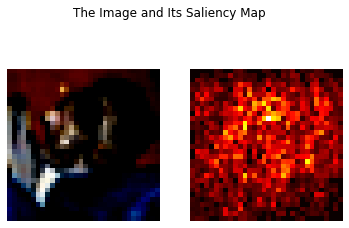

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


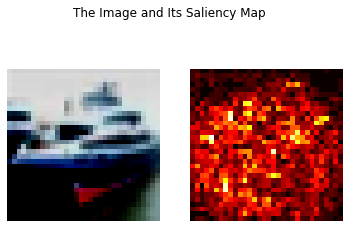

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


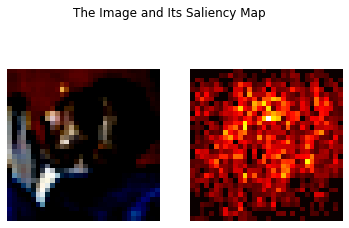

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


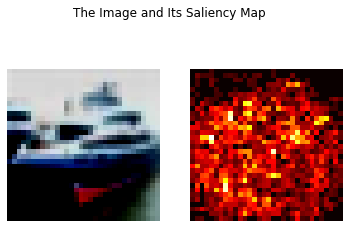

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


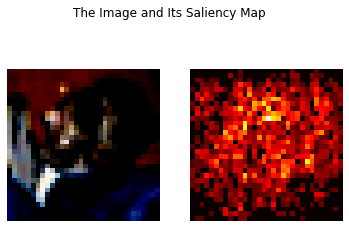

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


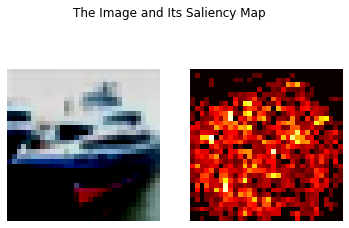

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


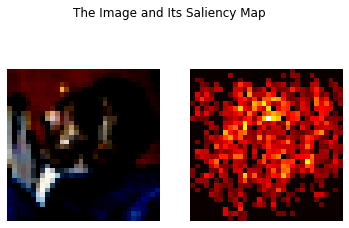

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


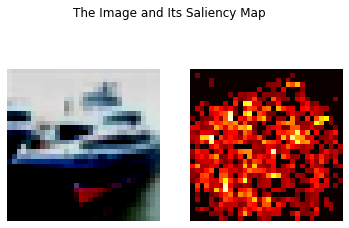

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


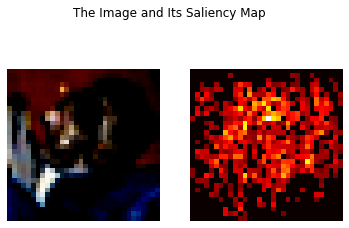

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


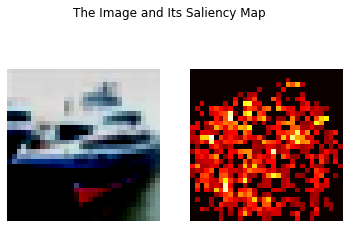

In [11]:
for k in [10,20,30,40,50]:
    
    for ind,data in enumerate(testloader):
        if ind >= 2:
            break
        image, label = data


        image, label = image.to(device), label.to(device)
        image.requires_grad_()

        # Retrieve output from the image
        output = teacher(image)

        # Catch the output
        output_idx = output.argmax()
        output_max = output[0, output_idx]

        # Do backpropagation to get the derivative of the output based on the image
        output_max.backward()

        # Retireve the saliency map and also pick the maximum value from channels on each pixel.
        # In this case, we look at dim=1. Recall the shape (batch_size, channel, width, height)
        saliency, _ = torch.max(image.grad.data.abs(), dim=1)
        saliency_val = np.percentile(saliency.cpu().numpy(), k)
        saliency[saliency < saliency_val] = 0
        saliency = saliency.reshape(32, 32)

        # Reshape the image
        image = image.reshape(-1, 32, 32)


        # Visualize the image and the saliency map
        # fig, ax = plt.subplots(1, 2)
        # ax[0].imshow(image[0].cpu().detach().numpy().transpose(1, 2, 0))
        # ax[0].axis('off')
        # ax[1].imshow(saliency[0].cpu(), cmap='hot')
        # ax[1].axis('off')


        # plt.tight_layout()
        # fig.suptitle('The Image and Its Saliency Map')
        # plt.show()

        # Visualize the image and the saliency map
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(image.cpu().detach().numpy().transpose(1, 2, 0))
        ax[0].axis('off')
        ax[1].imshow(saliency.cpu(), cmap='hot')
        ax[1].axis('off')

        fig.suptitle('The Image and Its Saliency Map')
        plt.show()

